## Image Effect Matrices Cross-Correlations

### Image DWT Cross-Correlations

For the 2-D DWT, we start with a similar procedure to the 1-D case, by performing a multi-level wavelet decomposition of the input signal. This produces a series of average and detail coefficients. However, rather than having a single detail coefficient at each level of decomposition, we actually have 3: the Horizontal, Vertical, and Diagonal detail coefficients. Therefore, the decomposition can be represented as follows:

$$
f = [A^m, D^m, V^m, H^m, D^{m-1}, V^{m-1}, H^{m-1} ... H^{1}]
$$

where $f$ is a vector of coefficients representing the entire decomposition, and $D^i, V^i, H^i$ are the vectors of diagonal, vertical, and horizontal detail coefficients, respectively, at decomposition level $i$. Each of these vectors is of length $ \frac{n}{2^i}$. 

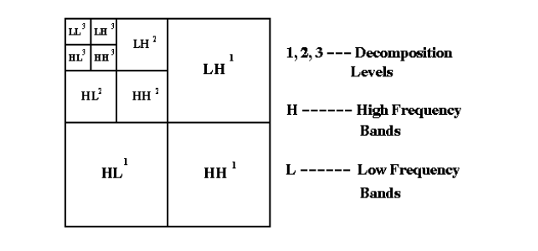

Note:
- 'H' refers to high-frequency bands and 'L' refers to low-frequency bands
- LL is $A^j$, the $j^{th}$-level average image
- HL (bottom left) is vertical fluctuation
- LH (top right) is horizontal fluctuation
- HH (bottom right) is diagonal fluctuation

Suppose we have decomposed 2 images. Then, for each of these coefficient vectors, we can calculate pixel-wise correlation. Unlike in the 1-D case, rather than having a single correlation coefficient $r_{XY}$, we now have 3 coefficients for each level of the decomposition, along with a fourth coefficient corresponding to the $m^{th}$-level average coefficient $A^m$. These coefficients are:

- $q_{11}$, the correlation coefficient between the average coefficients $A^m_X$ and $A^m_Y$
- $q_{2j}$, the correlation coefficient between the Horizontal detail coefficients at level $j$
- $q_{3j}$, the correlation coefficient between the Vertical detail coefficients at level $j$
- $q_{4j}$, the correlation coefficient between the Diagonal detail coefficients at level $j$

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Wavmat import Wavmat 
from idwtra import idwtra
from dwtrn import dwtrn
from scipy import signal

from statsmodels.tsa.ar_model import AutoReg
from scipy.stats import pearsonr, norm

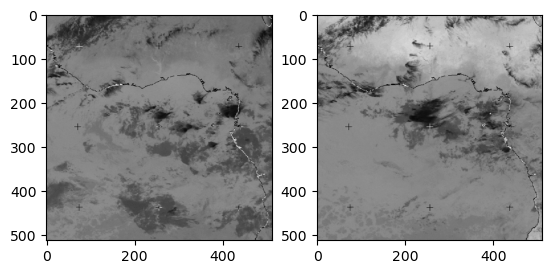

In [2]:
# testing image analysis
from PIL import Image
import math

jan4_6am = Image.open("images/images/D5M2001010406.gif")
jan4_12p = Image.open("images/images/D5M2001010412.gif")
jan4_6am = np.array(jan4_6am)
jan4_12p = np.array(jan4_12p)

#get dyadic dimensions (512x512)
jan4_6am = jan4_6am[44:556, 44:556]
jan4_12p = jan4_12p[44:556, 44:556]

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(jan4_6am, cmap='gray')
ax2.imshow(jan4_12p, cmap='gray')
plt.show()

In [49]:
from MakeONFilter import MakeONFilterExt

hfilt = MakeONFilterExt('Daubechies', 8)    # Coiflet 3

In [50]:
# wavelet decomp

a1 = dwtrn(jan4_6am, np.array([1]), hfilt)
a2 = dwtrn(jan4_6am, np.array([2]), hfilt)  
a3 = dwtrn(jan4_6am, np.array([3]), hfilt)

b1 = dwtrn(jan4_12p, np.array([1]), hfilt)
b2 = dwtrn(jan4_12p, np.array([2]), hfilt)  
b3 = dwtrn(jan4_12p, np.array([3]), hfilt)

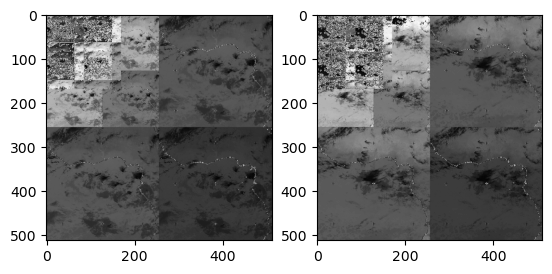

In [51]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(a3, cmap='gray')
ax2.imshow(b3, cmap='gray')
plt.show()

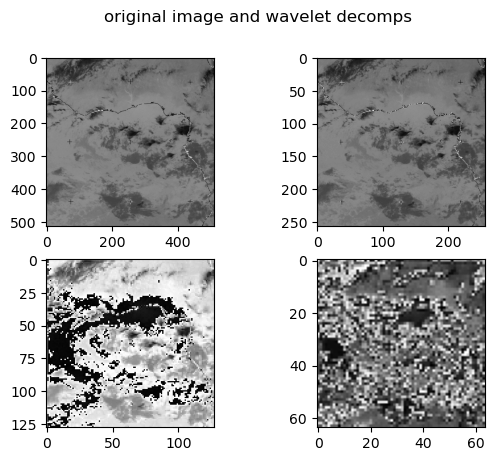

In [52]:
# extract wavelet coefficients at particular scales
a_l1 = a1[0:256, 0:256]
a_l2 = a2[0:128, 0:128]
a_l3 = a3[0:64, 0:64]

b_l1 = b1[0:256, 0:256]
b_l2 = b2[0:128, 0:128]
b_l3 = b3[0:64, 0:64]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.suptitle('original image and wavelet decomps')
ax1.imshow(jan4_6am, cmap='gray')
ax2.imshow(a_l1, cmap='gray')
ax3.imshow(a_l2, cmap='gray')
ax4.imshow(a_l3, cmap='gray')
plt.show()

In [53]:
# extract level matrices
def extract_levels(n, l, wd):
    dyadic = [64, 128, 256]
    
    A = wd[0:64, 0:64].reshape(-1)
    
    HL1 = wd[0:64, 64:128].reshape(-1)
    LH1 = wd[64:128, 0:64].reshape(-1)
    HH1 = wd[64:128, 64:128].reshape(-1)
    
    HL2 = wd[0:128, 128:256].reshape(-1)
    LH2 = wd[128:256, 0:128].reshape(-1)
    HH2 = wd[128:256, 128:256].reshape(-1)
    
    HL3 = wd[0:256, 256:512].reshape(-1)
    LH3 = wd[256:512, 0:256].reshape(-1)
    HH3 = wd[256:512, 256:512].reshape(-1)
    
    return A, HL1, LH1, HH1, HL2, LH2, HH2, HL3, LH3, HH3

In [ ]:
# turning the above into a general function
def extract_levels(n, l, wd):
    '''
    inputs:
    n  = length of input image (should be a power of 2)
    l  = number of levels of wavelet transform
    wd = nxn matrix of wavelet coefficients from the l-level wavelet transform
    
    returns:
    d  = a dictionary of unpacked levels of the wavelet decomposition. At each
         level, we get 3 arrays of coefficients corresponding to the LH, HL, 
         and HH components of the decomposed signal. Also contains the l-level 
         average signal A.
    '''
    
    dyadic = np.array([(n/2**(j+1)) for j in range(l)]).astype(int)
    dyadic = dyadic[::-1]
    
    A = wd[0:dyadic[0], 0:dyadic[0]].reshape(-1)
    
    # have to use a dictionary to dynamically create variables
    d = {}
    
    for i in range(l-1):
        d["LH{0}".format(i+1)] = wd[0:dyadic[i], dyadic[i]:dyadic[i+1]].reshape(-1)
        d["HL{0}".format(i+1)] = wd[dyadic[i]:dyadic[i+1], 0:dyadic[i]].reshape(-1)
        d["HH{0}".format(i+1)] = wd[dyadic[i]:dyadic[i+1], dyadic[i]:dyadic[i+1]].reshape(-1)
    
    return d

In [10]:
n=512
l = 3
dyadic = np.array([(n/2**(j+1)) for j in range(l)]).astype(int)
dyadic = dyadic[::-1]
dyadic

array([ 64, 128, 256])

In [54]:
a_l3 = extract_levels(512, 3, a3)
b_l3 = extract_levels(512, 3, b3)

In [55]:
# because of the nature of correlation, we can just unpack the images as arrays and correlate them
corrs = []

for i in range(10):
    corrs.append(np.corrcoef(a_l3[i], b_l3[i])[0,1])
    
corrs = np.array(corrs)
corrs

array([0.0218799 , 0.00805357, 0.07253914, 0.0877912 , 0.13147272,
       0.10159542, 0.17285798, 0.19336104, 0.17206419, 0.27257015])

In [ ]:
levels = ['A', 'HL1', 'LH1', 'HH1', 'HL2', 'LH2', 'HH2', 'HL3', 'LH3', 'HH3']
#          0     1      2      3      4      5      6      7      8      9

In [56]:
# prep data for correlation heatmap
Z = np.concatenate([np.array((corrs[0], corrs[7])), np.repeat(corrs[4], 2), np.repeat(corrs[1], 4),
                    np.array((corrs[8], corrs[9])), np.repeat(corrs[4], 2), np.repeat(corrs[1], 4),
                    np.repeat(corrs[5], 2), np.repeat(corrs[6], 2), np.repeat(corrs[1], 4),
                    np.repeat(corrs[5], 2), np.repeat(corrs[6], 2), np.repeat(corrs[1], 4),
                    np.repeat(corrs[2], 4), np.repeat(corrs[3], 4), np.repeat(corrs[2], 4), np.repeat(corrs[3], 4),
                    np.repeat(corrs[2], 4), np.repeat(corrs[3], 4), np.repeat(corrs[2], 4), np.repeat(corrs[3], 4)])

Z = Z.reshape((8,8))
Z = np.flipud(Z)

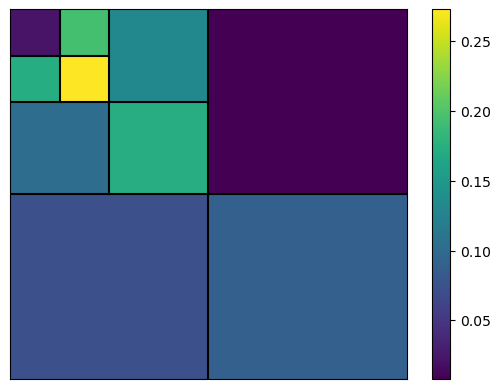

In [57]:
# correlation heatmap
x = np.arange(8)
y = np.arange(8)
X,Y = np.meshgrid(x,y)
#Z = np.concatenate((corrs[0:4], np.repeat(corrs[4], 2), np.repeat(corrs[4], 2)))

#Z = np.arange(64).reshape((len(y), len(x)))
# starts at bottom left and works L->R and bottom up
plt.pcolormesh(X,Y,Z)
plt.colorbar()
plt.plot([3.5, 3.5], [-0.5, 7.5], 'k-')
plt.plot([-0.5, 7.5], [3.5, 3.5], 'k-')

plt.plot([1.5, 1.5], [3.5, 7.5], 'k-')
plt.plot([-0.5, 3.5], [5.5, 5.5], 'k-')

plt.plot([0.5, 0.5], [5.5, 7.5], 'k-')
plt.plot([-0.5, 1.5], [6.5, 6.5], 'k-')

plt.xticks([])
plt.yticks([])
plt.show()

Some interesting things to note:
- the two images seem to be less correlated at the finer levels and more correlated at the sparser levels; this makes sense, as the coarser levels should in theory be picking up more of the underlying image rather than the weather fluctuations
- the level-3 average signals are not very correlated
- highest correlation occurs at the diagonal of level 3

In [91]:
corrs = []

corrs.append(np.corrcoef(a_l1, b_l1)[0,1])
corrs.append(np.corrcoef(a_l2, b_l2)[0,1])
corrs.append(np.corrcoef(a_l3, b_l3)[0,1])

corrs

[0.9250394062157407, 0.9380326331147538, 0.38510971058546595]

### Nondecimated Wavelet Transform

In [58]:
from WavmatND import WavmatND

In [64]:
np.random.seed(99)

n = 512
phi = 0.8

X = np.zeros(n)

for t in range(1,n):
    X[t] = X[t-1]*phi + np.random.standard_normal()

In [65]:
# test level-3 WD with nondecimated transform
# inputs: wavelet filter, size of an input signal, the depth of the transformation, and the shift

hfilt = MakeONFilterExt('Coiflet', 1)    # Coiflet 3

W = WavmatND(hfilt, 512, 3, shift=0)

wd_X = W * X

In [69]:
wd_m = wd_X[0:512, :]
wd_l1 = wd_X[512:1024, :]
wd_l2 = wd_X[1024:1536, :]
wd_l3 = wd_X[1536:1024, :]

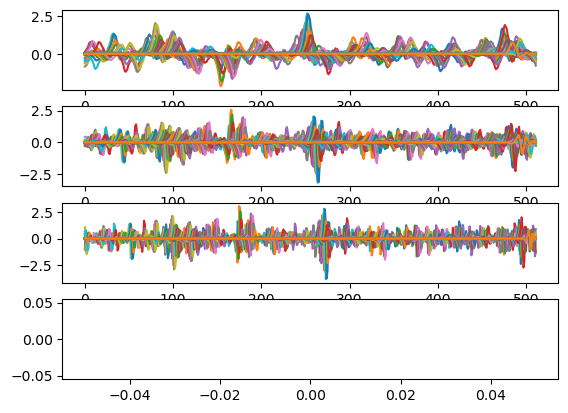

In [72]:
fig, ax = plt.subplots(4,1)
ax[0].plot(wd_m)
ax[1].plot(wd_l1)
ax[2].plot(wd_l2)
ax[3].plot(wd_l3)
plt.show()